In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate
import os

os.chdir('/Users/mabourqu/Desktop/cryobiome_revisions/')

This code was used for a grid search of the best C parameter (penalisation of coefficients), assessing the mean Accuracy for both PP1 and PP2. - It included these values: [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
- The best (and kept) C parameter value was 0.03 (balanced accuracy > 0.968)

# PP1

In [2]:
PP1_metadata = pd.read_csv('Metadata/PP1_metadata.tsv', sep='\t')
PP1_pres_abs = pd.read_csv('Data/trees/PP1_005_ASVs_table.csv')
PP1_pres_abs = PP1_pres_abs[PP1_metadata['Sample'].to_list()]
PP1_t = PP1_pres_abs.to_numpy()
PP1_t = PP1_t.transpose()
PP1_labels = np.array([1 if PP1_metadata[PP1_metadata['Sample'] == i]['Cryosphere'].values == 'Yes' else 0 for i in PP1_pres_abs.columns.to_list()])
print(PP1_t.shape)
print(PP1_labels.shape)

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    return([imp,names])

PP1_features_names = pd.read_csv('Data/trees/PP1_005_ASVs_table.csv',header = 0,usecols = [0])['ASV']
PP1_features_taxa = pd.read_csv('Data/trees/PP1_005_ASVs_table.csv',header = 0,usecols = [1])['Taxonomy']
print(PP1_features_names[1:3])
print(PP1_features_taxa[1:3])

(2508, 19353)
(2508,)
1    00038cf8efa9dce3ce68504e32337c18
2    0005af3e39f85478242c0e9a8def72cd
Name: ASV, dtype: object
1    d__Bacteria; p__Actinobacteriota; c__Actinobac...
2    d__Bacteria; p__Actinobacteriota; c__Actinobac...
Name: Taxonomy, dtype: object


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


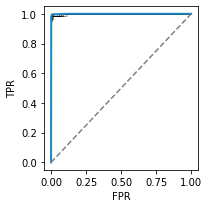

AUC: 0.9991900014768867 0.0005032997368105171
Balanced accuracy: 0.9816162815693744 0.011857668057117219
Precision: 0.9996073980970621 0.0009243904901226923
Recall: 0.9636174863387978 0.023937286801634223


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

classifier = LogisticRegression(solver = 'lbfgs',
                                random_state=23,
                                max_iter=1000,
                                penalty='l2',
                                C=0.178966,
                                class_weight='balanced')

PP1_tprs = []
PP1_aucs = []
PP1_mean_fpr = np.linspace(0, 1, 1000)
PP1_feature_imp_list = []
PP1_bal_acc = []
PP1_precision = []
PP1_recall = []

fig, ax = plt.subplots(figsize=(3,3))
for iteration in range(0,20):
    print(iteration)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = iteration)
    for i, (train, test) in enumerate(cv.split(PP1_t, PP1_labels)):

        classifier.fit(PP1_t[train], PP1_labels[train])
        
        # AUC curves
        viz = plot_roc_curve(classifier, PP1_t[test], PP1_labels[test],
                             sample_weight=np.array([1/(np.sum(PP1_labels[test] == 1)) if l == 1 else 1/(np.sum(PP1_labels[test] == 0)) for l in PP1_labels[test]]),
                             alpha=0.2, lw=1, ax=ax, color='black')
        
        interp_tpr = np.interp(PP1_mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        PP1_tprs.append(interp_tpr)
        PP1_aucs.append(viz.roc_auc)
        
        # Other metrics
        predictions = classifier.predict(PP1_t[test])
        PP1_bal_acc.append(accuracy_score(PP1_labels[test], predictions, sample_weight=np.array([1/(np.sum(PP1_labels[test] == 1)) if l == 1 else 1/(np.sum(PP1_labels[test] == 0)) for l in PP1_labels[test]])))
        PP1_precision.append(precision_score(PP1_labels[test], predictions, sample_weight=np.array([1/(np.sum(PP1_labels[test] == 1)) if l == 1 else 1/(np.sum(PP1_labels[test] == 0)) for l in PP1_labels[test]])))
        PP1_recall.append(recall_score(PP1_labels[test], predictions, sample_weight=np.array([1/(np.sum(PP1_labels[test] == 1)) if l == 1 else 1/(np.sum(PP1_labels[test] == 0)) for l in PP1_labels[test]])))
        
        # Storing SVM coefficients
        feat_imp = f_importances(classifier.coef_, PP1_features_names)
        PP1_feature_imp_list.append(feat_imp)
        
ax.get_legend().remove()
PP1_mean_tpr = np.mean(PP1_tprs, axis=0)
PP1_mean_tpr[-1] = 1.0
PP1_mean_auc = metrics.auc(PP1_mean_fpr, PP1_mean_tpr)
PP1_std_auc = np.std(PP1_aucs)

plt.hlines(y=1,xmin=0,xmax=1,linestyle='dashed',color='darkgrey')
ax.plot(PP1_mean_fpr, PP1_mean_tpr, color='#1A87BD',lw=2)
ax.set_ylim(-0.05,1.05)
ax.set_xlim(-0.05,1.05)
ax.plot([0,1],[0,1],'--',c='grey')
plt.ylabel('TPR')
plt.xlabel('FPR')

plt.tight_layout()
plt.savefig('1_ASV_analysis/1_1_Logistic_classifier/1_1_PP1_Logistic_roc.pdf')
plt.show()

PP1_feature_importance = np.exp(np.array([np.array(i[0]) for i in PP1_feature_imp_list]))
PP1_feature_importance_means = np.mean(PP1_feature_importance, axis=0)

PP1_importance_df = pd.DataFrame({'ASV':PP1_features_names,'Taxonomy':PP1_features_taxa,'Importance':PP1_feature_importance_means[0]})
PP1_importance_df.to_csv('Data/PP1_Logistics_coefs.csv',sep=',',index=False)

print('AUC:', PP1_mean_auc, PP1_std_auc)
print('Balanced accuracy:', np.mean(PP1_bal_acc), np.std(PP1_bal_acc))
print('Precision:', np.mean(PP1_precision), np.std(PP1_precision))
print('Recall:', np.mean(PP1_recall), np.std(PP1_recall))

# PP2

In [7]:
PP2_metadata = pd.read_csv('Metadata/PP2_metadata.tsv', sep='\t')
PP2_pres_abs = pd.read_csv('Data/trees/PP2_005_ASVs_table.csv')
PP2_pres_abs = PP2_pres_abs[PP2_metadata['Sample'].to_list()]
PP2_t = PP2_pres_abs.to_numpy()
PP2_t = PP2_t.transpose()
PP2_labels = np.array([1 if PP2_metadata[PP2_metadata['Sample'] == i]['Cryosphere'].values == 'Yes' else 0 for i in PP2_pres_abs.columns.to_list()])
print(PP2_t.shape)
print(PP2_labels.shape)

PP2_features_names = pd.read_csv('Data/trees/PP2_005_ASVs_table.csv',header = 0,usecols = [0])['ASV']
PP2_features_taxa = pd.read_csv('Data/trees/PP2_005_ASVs_table.csv',header = 0,usecols = [1])['Taxonomy']
print(PP2_features_names[1:3])
print(PP2_features_taxa[1:3])

(1739, 18296)
(1739,)
1    0003e5f611e467172b41ea746dbe7cce
2    000aab9b27c9d93615f5fb6ac9985d07
Name: ASV, dtype: object
1    d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...
2    d__Bacteria; p__Actinobacteriota; c__Actinobac...
Name: Taxonomy, dtype: object


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


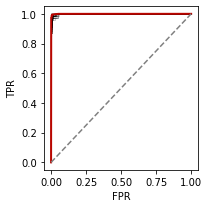

AUC: 0.9992572136700724 0.0003740631445551358
Balanced accuracy: 0.9749261211237118 0.013779444116298632
Precision: 0.9991825914124413 0.0015864760668507847
Recall: 0.950632911392405 0.027565276561237657


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

classifier = LogisticRegression(solver = 'lbfgs',
                                random_state=23,
                                max_iter=1000,
                                penalty='l2',
                                C=0.178966,
                                class_weight='balanced')

PP2_tprs = []
PP2_aucs = []
PP2_mean_fpr = np.linspace(0, 1, 1000)
PP2_feature_imp_list = []
PP2_bal_acc = []
PP2_precision = []
PP2_recall = []

fig, ax = plt.subplots(figsize=(3,3))
for iteration in range(0,20):
    print(iteration)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = iteration)
    for i, (train, test) in enumerate(cv.split(PP2_t, PP2_labels)):

        classifier.fit(PP2_t[train], PP2_labels[train])
        
        # AUC curves
        viz = plot_roc_curve(classifier, PP2_t[test], PP2_labels[test],
                             sample_weight=np.array([1/(np.sum(PP2_labels[test] == 1)) if l == 1 else 1/(np.sum(PP2_labels[test] == 0)) for l in PP2_labels[test]]),
                             alpha=0.2, lw=1, ax=ax, color='black')
        
        interp_tpr = np.interp(PP2_mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        PP2_tprs.append(interp_tpr)
        PP2_aucs.append(viz.roc_auc)
        
        # Other metrics
        predictions = classifier.predict(PP2_t[test])
        PP2_bal_acc.append(accuracy_score(PP2_labels[test], predictions, sample_weight=np.array([1/(np.sum(PP2_labels[test] == 1)) if l == 1 else 1/(np.sum(PP2_labels[test] == 0)) for l in PP2_labels[test]])))
        PP2_precision.append(precision_score(PP2_labels[test], predictions, sample_weight=np.array([1/(np.sum(PP2_labels[test] == 1)) if l == 1 else 1/(np.sum(PP2_labels[test] == 0)) for l in PP2_labels[test]])))
        PP2_recall.append(recall_score(PP2_labels[test], predictions, sample_weight=np.array([1/(np.sum(PP2_labels[test] == 1)) if l == 1 else 1/(np.sum(PP2_labels[test] == 0)) for l in PP2_labels[test]])))
        
        # Storing SVM coefficients
        feat_imp = f_importances(classifier.coef_, PP2_features_names)
        PP2_feature_imp_list.append(feat_imp)
        
ax.get_legend().remove()
PP2_mean_tpr = np.mean(PP2_tprs, axis=0)
PP2_mean_tpr[-1] = 1.0
PP2_mean_auc = metrics.auc(PP2_mean_fpr, PP2_mean_tpr)
PP2_std_auc = np.std(PP2_aucs)

plt.hlines(y=1,xmin=0,xmax=1,linestyle='dashed',color='darkgrey')
ax.plot(PP2_mean_fpr, PP2_mean_tpr, color='#BA0600',lw=2)
ax.set_ylim(-0.05,1.05)
ax.set_xlim(-0.05,1.05)
ax.plot([0,1],[0,1],'--',c='grey')
plt.ylabel('TPR')
plt.xlabel('FPR')

plt.tight_layout()
plt.savefig('1_ASV_analysis/1_1_Logistic_classifier/1_1_PP2_Logistic_roc.pdf')
plt.show()

PP2_feature_importance = np.exp(np.array([np.array(i[0]) for i in PP2_feature_imp_list]))
PP2_feature_importance_means = np.mean(PP2_feature_importance, axis=0)

PP2_importance_df = pd.DataFrame({'ASV':PP2_features_names,'Taxonomy':PP2_features_taxa,'Importance':PP2_feature_importance_means[0]})
PP2_importance_df.to_csv('Data/PP2_Logistic_coefs.csv',sep=',',index=False)

print('AUC:', PP2_mean_auc, PP2_std_auc)
print('Balanced accuracy:', np.mean(PP2_bal_acc), np.std(PP2_bal_acc))
print('Precision:', np.mean(PP2_precision), np.std(PP2_precision))
print('Recall:', np.mean(PP2_recall), np.std(PP2_recall))

# C optimisation

In [8]:
def GetBalAcc(classifier, labels, tab, max_iter):
    bal_acc = []
    for iteration in range(0,max_iter):
        print(iteration)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = iteration)
        for i, (train, test) in enumerate(cv.split(tab, labels)):
            classifier.fit(tab[train], labels[train])
            predictions = classifier.predict(tab[test])
            bal_acc.append(accuracy_score(labels[test], predictions, sample_weight=np.array([1/(np.sum(labels[test] == 1)) if l == 1 else 1/(np.sum(labels[test] == 0)) for l in labels[test]])))
    return(np.mean(bal_acc))


In [9]:
c_values = np.linspace(0.01,0.5,30)
print(c_values)

[0.01       0.02689655 0.0437931  0.06068966 0.07758621 0.09448276
 0.11137931 0.12827586 0.14517241 0.16206897 0.17896552 0.19586207
 0.21275862 0.22965517 0.24655172 0.26344828 0.28034483 0.29724138
 0.31413793 0.33103448 0.34793103 0.36482759 0.38172414 0.39862069
 0.41551724 0.43241379 0.44931034 0.4662069  0.48310345 0.5       ]


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score

c_opt_df = pd.DataFrame(columns=['C','Dataset','Bal_acc'])
for c in c_values:
    print(c)
    classifier = LogisticRegression(solver = 'lbfgs',
                                    random_state=23,
                                    max_iter=1000,
                                    penalty='l2',
                                    C=c,
                                    class_weight='balanced')

    PP1_acc = GetBalAcc(classifier, PP1_labels, PP1_t, 5)
    PP2_acc = GetBalAcc(classifier, PP2_labels, PP2_t, 5)
    c_opt_df = c_opt_df.append({'C':c,'Dataset':'Avg','Bal_acc':np.mean([PP1_acc,PP2_acc])}, ignore_index=True)
    c_opt_df = c_opt_df.append({'C':c,'Dataset':'PP1','Bal_acc':PP1_acc}, ignore_index=True)
    c_opt_df = c_opt_df.append({'C':c,'Dataset':'PP2','Bal_acc':PP2_acc}, ignore_index=True)

0.01
0
1
2
3
4
0
1
2
3
4
0.026896551724137928
0
1
2
3
4
0
1
2
3
4
0.04379310344827586
0
1
2
3
4
0
1
2
3
4
0.060689655172413794
0
1
2
3
4
0
1
2
3
4
0.07758620689655171
0
1
2
3
4
0
1
2
3
4
0.09448275862068964
0
1
2
3
4
0
1
2
3
4
0.11137931034482758
0
1
2
3
4
0
1
2
3
4
0.12827586206896552
0
1
2
3
4
0
1
2
3
4
0.14517241379310344
0
1
2
3
4
0
1
2
3
4
0.16206896551724137
0
1
2
3
4
0
1
2
3
4
0.1789655172413793
0
1
2
3
4
0
1
2
3
4
0.19586206896551722
0
1
2
3
4
0
1
2
3
4
0.21275862068965518
0
1
2
3
4
0
1
2
3
4
0.2296551724137931
0
1
2
3
4
0
1
2
3
4
0.24655172413793103
0
1
2
3
4
0
1
2
3
4
0.2634482758620689
0
1
2
3
4
0
1
2
3
4
0.2803448275862069
0
1
2
3
4
0
1
2
3
4
0.29724137931034483
0
1
2
3
4
0
1
2
3
4
0.31413793103448273
0
1
2
3
4
0
1
2
3
4
0.3310344827586207
0
1
2
3
4
0
1
2
3
4
0.3479310344827586
0
1
2
3
4
0
1
2
3
4
0.36482758620689654
0
1
2
3
4
0
1
2
3
4
0.38172413793103444
0
1
2
3
4
0
1
2
3
4
0.3986206896551724
0
1
2
3
4
0
1
2
3
4
0.41551724137931034
0
1
2
3
4
0
1
2
3
4
0.43241379310344824


In [11]:
print(c_opt_df)

           C Dataset   Bal_acc
0   0.010000     Avg  0.964577
1   0.010000     PP1  0.983858
2   0.010000     PP2  0.945295
3   0.026897     Avg  0.971535
4   0.026897     PP1  0.984053
..       ...     ...       ...
85  0.483103     PP1  0.977216
86  0.483103     PP2  0.975506
87  0.500000     Avg  0.976361
88  0.500000     PP1  0.977216
89  0.500000     PP2  0.975506

[90 rows x 3 columns]


In [12]:
c_avg_acc = c_opt_df[c_opt_df['Dataset'] == 'Avg']
c_avg_acc[c_avg_acc['Bal_acc'] == np.max(c_avg_acc['Bal_acc'])]
# 0.466207 smaller value with max mean balanced accuracy across PP1 and PP2

,C,Dataset,Bal_acc
30,0.178966,Avg,0.977741
33,0.195862,Avg,0.977741
